In [1]:
import torch
from torch import Tensor
from torch.nn import functional as F
from torch import nn
from torch.distributions.categorical import Categorical
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm

In [2]:
torch.manual_seed(3)

In [3]:
def con_t(i: Tensor, n: Tensor, minimum: float=1e-6):
  assert torch.all(i <= n), "i must be less than or equal to n"
  assert torch.all(n > 0), "n must be at least 1"
  assert torch.all(i > 0), "i must be at least 1"
  return torch.clamp((i - 1) / n, min=minimum)

In [4]:
def con_gamma(t, sigma_1):
  assert torch.all(t > 0) and torch.all(t <= 1), "time must be greater than 0 and less or equal to 1"
  return 1 - sigma_1 ** t

In [5]:
def con_mu(gamma, x):
  gamma = gamma.view(-1, 1, 1)
  mean = gamma * x
  variance = gamma * (1 - gamma)
  std_dev = torch.sqrt(torch.clamp(variance, min=1e-8))
  epsilon = torch.normal(0, 1, x.shape, device=x.device)
  return mean + std_dev * epsilon

In [6]:
def con_reparameterized_x_pred(model_output, mu, gamma, clip_min=None, clip_max=None):
  gamma = gamma.view(-1,1,1)
  scaling_factor = torch.sqrt((1 - gamma) / gamma)
  x_prime = (mu / gamma) - (scaling_factor * model_output)
  if clip_min is not None or clip_max is not None:
    x_prime = torch.clamp(x_prime, min=clip_min, max=clip_max)
  return x_prime

In [7]:
continous_truth = torch.tensor([
    [
        [0.2, 0.8, 0.1, 0.9],
        [0.3, 0.4, 0.2, 0.8]
    ],
    [
        [0.5, 0.7, 0.0, 0.1],
        [0.4, 0.8, 0.9, 1.0]
    ]
])

In [8]:
continous_truth.shape

torch.Size([2, 2, 4])

In [9]:
t = torch.tensor([0.05, 0.5])

In [10]:
sigma_1 = torch.tensor([0.001, 0.002])

In [11]:
sigma_1 ** (2 * t)

tensor([0.5012, 0.0020])

In [12]:
gamma = con_gamma(t, sigma_1)

In [13]:
mu = con_mu(gamma, continous_truth)

In [14]:
class ContinuousModel(nn.Module):
  def __init__(self, max_seq_len: int, K: int, hidden_dim: int, num_heads: int, layers: int = 3, dropout: float = 0.1):
    super().__init__()
    assert hidden_dim % num_heads == 0, "hidden_dim must be divisble by num_heads"
    self.emb = nn.Parameter(torch.randn(K, hidden_dim))
    self.pos_emb = nn.Parameter(torch.randn(max_seq_len, hidden_dim))
    self.time_vec = nn.Parameter(torch.randn(1, hidden_dim))
    self.layers = nn.ModuleList(
        [
            nn.TransformerEncoderLayer(
                hidden_dim,
                num_heads,
                hidden_dim*4,
                dropout,
                batch_first=True,
                bias=False
                ) for i in range(layers)
        ]
    )
    self.classifier = nn.Parameter(torch.randn(hidden_dim, K))

  def token_emb(self, x):
    return x @ self.emb

  def positional_emb(self, x):
    return x + self.pos_emb[:x.shape[1]]

  def time_emb(self, x, t):
    assert torch.all(t >= 0) and torch.all(t <= 1), "time must be in range [0, 1]"
    # we need to first unsqueeze t to get it from shape (batch_size,)
    # to (batch_size, 1) so it is compatible with the time_vec's (1, hidden_dim)
    # the result is (batch_size, hidden_dim) however the x is
    # (batch_size, seq_len, hidden_dim) so we need a second unsqueeze
    return (t.unsqueeze(-1) @ self.time_vec).unsqueeze(-2) + x

  def forward(self, x,  t):
    x = self.token_emb(x)
    x = self.positional_emb(x)
    x = self.time_emb(x, t)
    for i, l in enumerate(self.layers):
      x = l.forward(x)
    return x @ self.classifier

In [15]:
batch_size, seq_len, pixels = continous_truth.shape

In [16]:
continous_truth.shape

torch.Size([2, 2, 4])

In [17]:
model = ContinuousModel(seq_len, pixels, 64, 8)

In [18]:
output = model(mu, t)

In [19]:
output

tensor([[[  4.0016,  12.1084,  -2.9912,   3.7942],
         [ 10.6730, -14.4573,  11.5441,  13.2375]],

        [[  5.9914,  -3.8749,   7.3435,   0.3989],
         [  4.7369,  -7.7881,  11.2527,   6.2900]]],
       grad_fn=<UnsafeViewBackward0>)

In [20]:
x_prime = con_reparameterized_x_pred(output, mu, gamma, 0, 1) # since we know the truth is in [0, 1]

In [21]:
x_prime

tensor([[[0., 0., 1., 0.],
         [0., 1., 0., 0.]],

        [[0., 1., 0., 0.],
         [0., 1., 0., 0.]]], grad_fn=<ClampBackward1>)

In [22]:
def con_loss(sigma_1, t, truth, pred):
  batch_size, seq_len, _ = truth.shape
  # we do batch_size ** 2 since the first division normalizes the truth - pred,
  # the second division normalizes the sigma_1 and t batch dimension
  # then divide by sequence length to normalize by seq len
  return torch.sum(-torch.log(sigma_1) * ((torch.sum((truth - pred) ** 2) / (sigma_1 ** (2 * t))) / (batch_size**2))) / seq_len

In [23]:
def con_accuracy(sigma_1, i, n):
  assert torch.all(n > 0), "Must have at least one inference step"
  assert torch.all(i > 0), "Must be at the first inference step or later"
  assert torch.all(i <= n), "Cannot be past last inference step"
  return (sigma_1 ** (-2 * i / n)) * (1 - sigma_1 ** (2 / n))

In [24]:
def con_y(accuracy, x_prime):
  epsilon = torch.normal(0, 1, x_prime.shape, device=x_prime.device)
  std_dev = 1.0 / torch.sqrt(torch.clamp(accuracy, min=1e-8))
  return x_prime + epsilon * std_dev.view(-1, 1, 1)

In [25]:
def con_new_precision(accuracy, old_precision):
  return old_precision + accuracy

In [26]:
def con_bayesian_update(old_precision, new_precision, accuracy, y, model_input):
  return (model_input * old_precision.view(-1,1,1) + y * accuracy.view(-1,1,1)) / new_precision.view(-1,1,1)

In [27]:
def con_bayesian_inference(model_input, model_output_x_prime, sigma_1, i, n, precision):
  accuracy = con_accuracy(sigma_1, i, n)
  y = con_y(accuracy, model_output_x_prime)
  new_precision = con_new_precision(accuracy, precision)
  mu_prime = con_bayesian_update(precision, new_precision, accuracy, y, model_input)
  return mu_prime, new_precision

In [28]:
i = torch.tensor([1,2])
n = torch.tensor([20,21])
precision = torch.tensor([1.1, 2.2])

In [29]:
con_bayesian_inference(mu, x_prime, sigma_1, i, n, precision)

(tensor([[[ 0.5542,  0.1195,  0.5815,  0.2143],
          [-0.0590,  0.0011,  0.4698, -0.4498]],
 
         [[ 0.0914,  0.9022, -0.1616, -0.1021],
          [-0.6236,  0.8860,  1.0372,  0.7749]]], grad_fn=<DivBackward0>),
 tensor([2.0953, 3.6592]))

In [30]:
def generate_sequence(length: int, mini: int = 0, maxi: int = 100):
  start = random.randint(mini, maxi - length)
  end = start + length
  acc = torch.arange(start, end) / maxi
  return acc

In [31]:
class ContinuousSynthetic(Dataset):
  def __init__(self, length: int = 32, pixels: int = 32, mini: int = 0, maxi: int = 100):
    self.length = length
    self.pixels = pixels
    self.mini = mini
    self.maxi = maxi

  def __len__(self):
    return 10000

  def __getitem__(self, idx):
    sequence = [generate_sequence(self.pixels, self.mini, self.maxi) for i in range(self.length)]
    return torch.stack(sequence)

In [32]:
def make_infinite(dl):
  while True:
    for data in dl:
      yield data

In [33]:
length = 5
pixels = 4
train_ds = ContinuousSynthetic(length, pixels)

In [34]:
batch_size = 32 * 6 * 2

In [35]:
train_dl = DataLoader(train_ds, batch_size=batch_size)
train_dl = make_infinite(train_dl)

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [37]:
model = ContinuousModel(length, pixels, 64, 8)

In [38]:
model = model.to(device)

In [39]:
opt = AdamW(model.parameters())

In [40]:
n = 10

In [41]:
model_input = torch.randn((1, length, pixels)).to(device)

In [42]:
precision = torch.tensor([0]).to(device)

In [43]:
sigma_1 = torch.tensor([0.001]).to(device)

In [44]:
with torch.no_grad():
  for i in range(1, n):
    if i % 10 == 0:
      print(model_input)
    cur_i = torch.tensor([i]).to(device)
    cur_n = torch.tensor([n]).to(device)
    t = con_t(cur_i, cur_n)
    gamma = con_gamma(t, sigma_1)
    model_output = model(model_input, t)
    x_prime = con_reparameterized_x_pred(model_output, model_input, gamma, 0, 1)  # since we know the truth is in [0, 1]
    model_input, precision = con_bayesian_inference(model_input, x_prime, sigma_1, cur_i, cur_n, precision)

/media/john/Tertiary/Projects/ML/BayesianFlowNetwork/.venv/lib/python3.11/site-packages/torch/nn/functional.py:5560: UserWarning: Flash attention support on Navi31 GPU is still experimental. Enable it with TORCH_ROCM_AOTRITON_ENABLE_EXPERIMENTAL=1. (Triggered internally at /pytorch/aten/src/ATen/native/transformers/hip/sdp_utils.cpp:207.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
/media/john/Tertiary/Projects/ML/BayesianFlowNetwork/.venv/lib/python3.11/site-packages/torch/nn/functional.py:5560: UserWarning: Memory Efficient attention on Navi31 GPU is still experimental. Enable it with TORCH_ROCM_AOTRITON_ENABLE_EXPERIMENTAL=1. (Triggered internally at /pytorch/aten/src/ATen/native/transformers/hip/sdp_utils.cpp:251.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


In [45]:
def sample_t(batch_size, min_t=1e-6):
  return torch.clamp(torch.FloatTensor(batch_size).uniform_(0,1), min=min_t)

In [46]:
losses = []

In [100]:
epochs = 40000

In [101]:
for i in tqdm(range(epochs)):
  opt.zero_grad()
  ground_truth = next(train_dl).to(device)
  batch_size, seq_len, pixels = ground_truth.shape
  t = sample_t(batch_size).to(device)
  sigma_1 = torch.ones((batch_size), device=device) * 0.001
  gamma = con_gamma(t, sigma_1)
  mu = con_mu(gamma, ground_truth)
  output = model(mu, t)
  x_prime = con_reparameterized_x_pred(output, mu, gamma, 0, 1)  # since we know the truth is in [0, 1]
  loss = con_loss(sigma_1, t, ground_truth, x_prime)
  loss.backward()
  losses.append(loss.item())
  # torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
  opt.step()

  0%|          | 0/40000 [00:00<?, ?it/s]

In [102]:
losses[-1]

46409.7578125

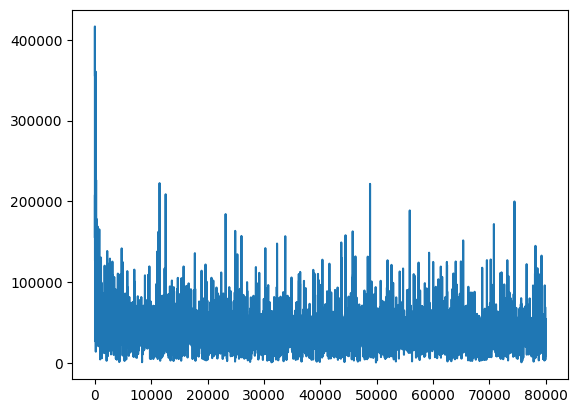

In [103]:
plt.plot(losses)

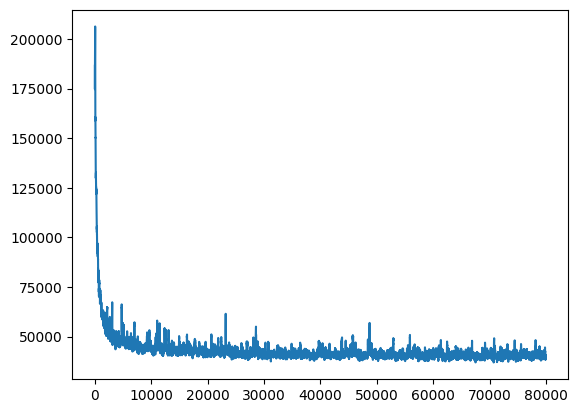

In [104]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Usage
smoothed_losses = moving_average(losses, window_size=50)
plt.plot(smoothed_losses)

In [131]:
# model_input = torch.randn((1, length, pixels)).to(device)
model_input = torch.zeros((1, length, pixels)).to(device)

In [132]:
model_input

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]], device='cuda:0')

In [133]:
precision = torch.tensor([0]).to(device)

In [134]:
sigma_1 = torch.tensor([0.001]).to(device)

In [135]:
i = 1
n = 100
cur_i = torch.tensor([i]).to(device)
cur_n = torch.tensor([n]).to(device)
t = con_t(cur_i, cur_n)

In [136]:
model_output = model(model_input, t)

In [137]:
model_output

tensor([[[ 0.0093,  0.0673,  0.0252, -0.0374],
         [ 0.1294,  0.1667, -0.0559,  0.0133],
         [ 0.1708,  0.1325, -0.0372, -0.0834],
         [ 0.0334,  0.0355, -0.0599, -0.0371],
         [ 0.0608,  0.1215, -0.0244, -0.0411]]], device='cuda:0',
       grad_fn=<UnsafeViewBackward0>)

In [138]:
gamma = con_gamma(t, sigma_1)

In [139]:
con_reparameterized_x_pred(model_output, model_input, gamma)

tensor([[[ -3.5371, -25.5993,  -9.5701,  14.2270],
         [-49.2143, -63.3940,  21.2572,  -5.0642],
         [-64.9565, -50.4009,  14.1289,  31.7055],
         [-12.6999, -13.4859,  22.7835,  14.0985],
         [-23.1194, -46.1971,   9.2800,  15.6393]]], device='cuda:0',
       grad_fn=<SubBackward0>)

In [140]:
con_reparameterized_x_pred(model_output, model_input, gamma, 0, 1)

tensor([[[0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 1., 1.],
         [0., 0., 1., 1.],
         [0., 0., 1., 1.]]], device='cuda:0', grad_fn=<ClampBackward1>)

In [141]:
#(mu / gamma) - (scaling_factor * model_output)
gamma

tensor([6.9141e-06], device='cuda:0')

In [142]:
with torch.no_grad():
  for i in range(1, n):
    if i % 10 == 0:
      print(model_input)
    cur_i = torch.tensor([i]).to(device)
    cur_n = torch.tensor([n]).to(device)
    t = con_t(cur_i, cur_n)
    gamma = con_gamma(t, sigma_1)
    model_output = model(model_input, t)
    x_prime = con_reparameterized_x_pred(model_output, model_input, gamma, 0, 1)  # since we know the truth is in [0, 1]
    model_input, precision = con_bayesian_inference(model_input, x_prime, sigma_1, cur_i, cur_n, precision)

tensor([[[ 0.9307,  0.5888,  1.6692,  0.6300],
         [ 0.2518,  1.1470, -0.6628,  0.2824],
         [ 1.2191, -0.5268, -0.6808,  0.5767],
         [ 1.0518,  0.4856,  0.8378, -0.9348],
         [ 0.7424,  0.5963,  0.2455,  0.7438]]], device='cuda:0')
tensor([[[ 7.2531e-01,  1.2313e+00,  1.2937e+00,  4.9912e-01],
         [ 3.8305e-01,  2.6932e-01, -1.4542e-01,  6.8808e-04],
         [ 7.5259e-01,  6.2199e-01,  2.1326e-01,  8.1611e-01],
         [ 1.3298e-01,  1.7118e-01,  1.2807e-01,  2.7009e-01],
         [ 7.3531e-01,  7.8519e-01,  5.5540e-01,  1.0507e+00]]],
       device='cuda:0')
tensor([[[1.1424, 0.9161, 0.9187, 0.7955],
         [0.1648, 0.3420, 0.2065, 0.2149],
         [0.4203, 0.6360, 0.5806, 1.1260],
         [0.4972, 0.2970, 0.5307, 0.4561],
         [0.8305, 0.5529, 0.7858, 0.9036]]], device='cuda:0')
tensor([[[0.8733, 0.9907, 0.8828, 0.7806],
         [0.2438, 0.4122, 0.2389, 0.3670],
         [0.6909, 0.8470, 0.6791, 0.8961],
         [0.4733, 0.5885, 0.6140, 0.5906],

In [143]:
x_prime

tensor([[[0.8773, 0.9148, 0.8901, 0.9296],
         [0.4317, 0.4387, 0.4463, 0.4849],
         [0.8607, 0.8507, 0.8758, 0.8928],
         [0.5919, 0.6092, 0.6082, 0.6198],
         [0.8301, 0.8490, 0.8578, 0.8693]]], device='cuda:0')